In [11]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [12]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct
from pathlib import Path



# Create a reference to the file. 
database_path = Path("../Resources/hawaii.sqlite")


In [14]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()



# reflect the tables
Base.prepare(autoload_with=engine)

In [16]:
# View all of the classes that automap found
inspector = inspect(engine)

inspector.get_table_names()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement




In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [19]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [20]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

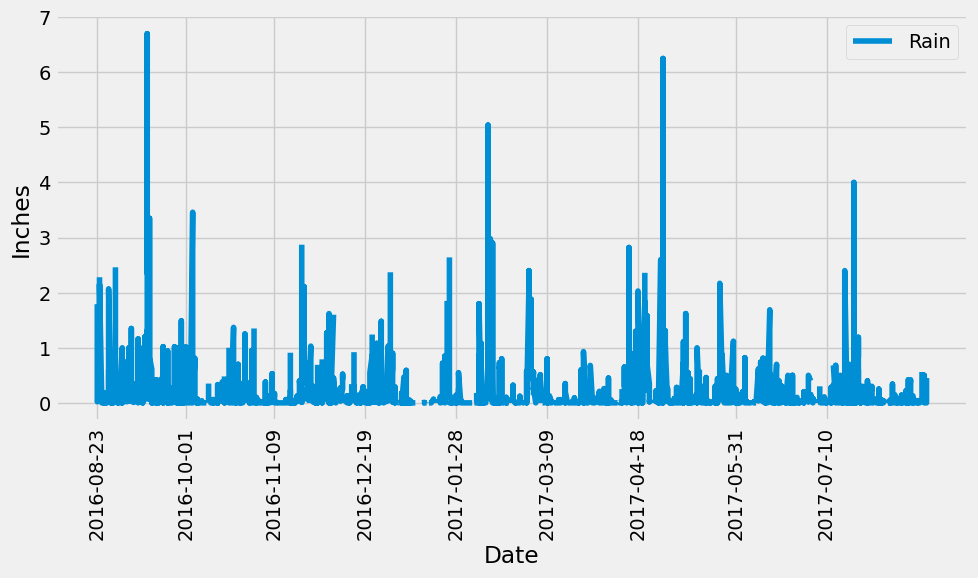

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.datetime(2017, 8, 23)


# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
rain_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= func.date(one_year_ago)).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
rain_df = pd.DataFrame(rain_data, columns=["Date", "Rain"])

# Sort the dataframe by date
rain_df = rain_df.sort_values(by="Date")


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(rain_df["Date"], rain_df["Rain"], label="Rain")
plt.xlabel("Date")
plt.ylabel("Inches")

custom_xticks = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10']
plt.xticks(custom_xticks, rotation=90)

plt.legend()

plt.tight_layout()
plt.show()


In [22]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = rain_df.describe()
summary_stats

,Rain
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(distinct(Measurement.station))).all()
total_stations

[(9,)]

In [24]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_temps = session.query(func.min(Measurement.tobs),
                                          func.max(Measurement.tobs),
                                          func.avg(Measurement.tobs))\
                                          .filter(Measurement.station == "USC00519281")\
                                          .all()

most_active_station_temps

[(54.0, 85.0, 71.66378066378067)]

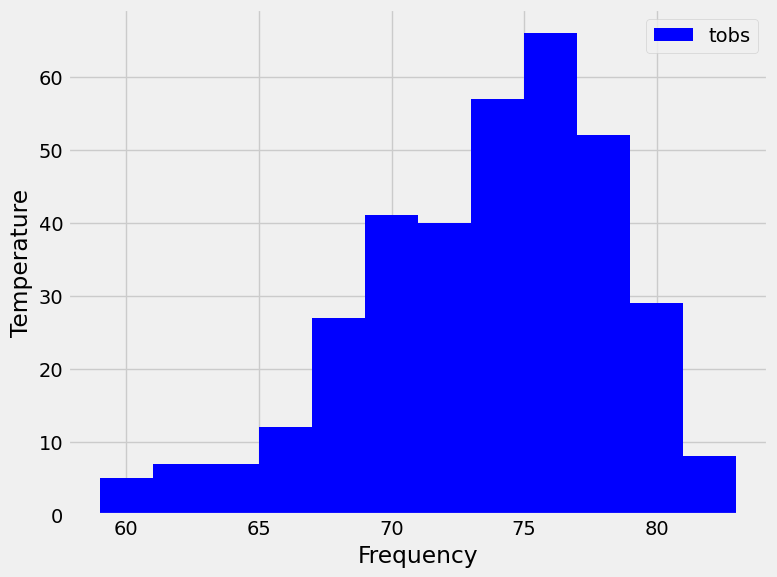

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281")\
                                            .filter(Measurement.date >= one_year_ago)\
                                            .filter(Measurement.date <= most_recent_date)\
                                            .all()

temps = [temp[0] for temp in temp_data]

plt.figure(figsize=(8, 6))
plt.hist(temps, bins=12, color='blue', label="tobs")
plt.xlabel("Frequency")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [27]:
# Close Session
session.close()